# Quickstart Example of Off-Policy Evaluation with Various Estimators (Continuous)
This notebook provides an example of conducting **Off-policy Evaluation (OPE)** with a basic synthetic  dataset and various OPE estimators (e.g., model-based vs importance sampling-based, marginal importance sampling, and double reinforcement learning).

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Off-Policy Evaluation (OPE) with various estimators

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../../')
sys.path.append('../../../')

In [4]:
# import OFRL modules
import ofrl
from basicgym import BasicEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for Basic Synthetic
In Basic Synthetic, the objective of the RL agent is to maximize reward.

We often formulate this synthetic  problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: State observation, which may be noisy in POMDPs.
- `action`:  Indicating the action to presented by the RL agent.
- `reward`: Reward observation.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/basic/basic_synthetic_customize_env.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/basic/basic_synthetic_customize_env.ipynb).

In [9]:
# standardized environment for continuous action
env = gym.make("BasicEnv-continuous-v0")

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Basic synthetic environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

For more about the data collection and visualization, please refer to [examples/quickstart/basic/basic_synthetic_data_collection.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/basic/basic_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [12]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2023-03-19 20:01.18 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230319200118
2023-03-19 20:01.18 [debug    ] Fitting action scaler...       action_scler=min_max
2023-03-19 20:01.18 [debug    ] Building model...
2023-03-19 20:01.18 [debug    ] Model has been built.
2023-03-19 20:01.18 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230319200118/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': 

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-03-19 20:01.18 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230319200118/model_1000.pt
2023-03-19 20:01.18 [info     ] SAC_online_20230319200118: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00025036311149597166, 'time_environment_step': 2.9256105422973634e-05, 'time_step': 0.0002894294261932373, 'rollout_return': 0.679303480495422, 'evaluation': 2.1073239476518806} step=1000
2023-03-19 20:01.21 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230319200118/model_2000.pt
2023-03-19 20:01.21 [info     ] SAC_online_20230319200118: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00025652241706848144, 'time_environment_step': 3.8149595260620116e-05, 'time_sample_batch': 8.380985260009766e-05, 'time_algorithm_update': 0.0026607699394226073, 'temp_loss': 4.318270388126373, 'temp': 0.8692206496596336, 'critic_loss': 3.9523945808410645, 'actor_loss': -3.8461191285848617, 'time_step': 0.0030576999187469484, 'rollout_return': 1.0509804

In [13]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [14]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

2023-03-19 20:06.42 [warning  ] Parameters will be reinitialized.


In [15]:
behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [16]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [17]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
with open("logs/train_dataset_continuous_sac.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_sac.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [19]:
with open("logs/train_dataset_continuous_sac.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_sac.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb).

In [20]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL
# transform offline dataset for d3rlpy
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
    episode_terminals=train_logged_dataset["done"],
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [21]:
# Use Conservative Q-Learning policy
cql = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [22]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

2023-03-19 20:08.45 [debug    ] RandomIterator is selected.
2023-03-19 20:08.45 [info     ] Directory is created at d3rlpy_logs/CQL_20230319200845
2023-03-19 20:08.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-19 20:08.45 [debug    ] Building models...
2023-03-19 20:08.45 [debug    ] Models have been built.
2023-03-19 20:08.45 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230319200845/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-19 20:10.58 [info     ] CQL_20230319200845: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005027101993560791, 'time_algorithm_update': 0.012410451364517213, 'temp_loss': 3.127224356329441, 'temp': 0.6513270098924637, 'alpha_loss': -29.515616976928712, 'alpha': 1.794004876089096, 'critic_loss': 32.14822757530212, 'actor_loss': -4.35006745698452, 'time_step': 0.013268731474876404} step=10000
2023-03-19 20:10.58 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230319200845/model_10000.pt


[(1,
  {'time_sample_batch': 0.0005027101993560791,
   'time_algorithm_update': 0.012410451364517213,
   'temp_loss': 3.127224356329441,
   'temp': 0.6513270098924637,
   'alpha_loss': -29.515616976928712,
   'alpha': 1.794004876089096,
   'critic_loss': 32.14822757530212,
   'actor_loss': -4.35006745698452,
   'time_step': 0.013268731474876404})]

In [23]:
# save model
cql.save_model("d3rlpy_logs/cql_continuous.pt")

In [24]:
# reload model
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_continuous.pt")

2023-03-19 20:13.39 [warning  ] Parameters will be reinitialized.


## 2. Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner using (basic) model-based and importance sampling-based estimators.

#### Estimation Target

The goal to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [25]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
# basic estimators
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
# self normalized estimators
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
# marginal estimators
from ofrl.ope import ContinuousStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import ContinuousStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import ContinuousStateMarginalImportanceSampling as SMIS
from ofrl.ope import ContinuousStateMarginalDoublyRobust as SMDR
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import ContinuousStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import ContinuousStateMarginalSelfNormalizedDoublyRobust as SMSNDR
# double reinforcement learning estimators
from ofrl.ope import ContinuousDoubleReinforcementLearning as DRL

In [26]:
# define evaluation policies (should be deterministic policy)
cql_ = ContinuousEvalHead(
    base_policy=cql,
    name="cql",
)
sac_ = ContinuousEvalHead(
    base_policy=sac, 
    name="sac", 
)
evaluation_policies = [cql_, sac_]

In [27]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        },
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    gamma=0.95,
    sigma=0.1,
    device="cuda:0" if torch.cuda.is_available() else "cpu",
)

In [28]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    require_weight_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-19 20:13.40 [debug    ] RoundIterator is selected.
2023-03-19 20:13.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230319201340
2023-03-19 20:13.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-19 20:13.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-19 20:13.40 [debug    ] Building models...
2023-03-19 20:13.40 [debug    ] Models have been built.
2023-03-19 20:13.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230319201340/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-19 20:13.41 [info     ] FQE_20230319201340: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.942818641662598e-05, 'time_algorithm_update': 0.0009328658580780029, 'loss': 0.10269865382835269, 'time_step': 0.0010593438148498535} step=1000
2023-03-19 20:13.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230319201340/model_1000.pt
2023-03-19 20:13.41 [debug    ] RoundIterator is selected.
2023-03-19 20:13.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230319201341
2023-03-19 20:13.41 [debug    ] Fitting scaler...              scaler=min_max
2023-03-19 20:13.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-19 20:13.41 [debug    ] Building models...
2023-03-19 20:13.41 [debug    ] Models have been built.
2023-03-19 20:13.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230319201341/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}},

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-19 20:13.42 [info     ] FQE_20230319201341: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.614277839660645e-05, 'time_algorithm_update': 0.0008436858654022217, 'loss': 0.12393640379235149, 'time_step': 0.0009599514007568359} step=1000
2023-03-19 20:13.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230319201341/model_1000.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
with open("logs/ope_input_dict_continuous_zoo.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [30]:
with open("logs/ope_input_dict_continuous_zoo.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [31]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

In [32]:
basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [33]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=all_estimators,
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [34]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(
    input_dict, 
    random_state=random_state,
)
# dictionary of the estimation
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy  2.643372e+00           1.000000e+00
 dm         1.373144e+00           5.194670e-01
 tis        4.002299e-61           1.514089e-61
 pdis      -1.097753e-05          -4.152851e-06
 dr         1.373152e+00           5.194699e-01
 sntis      4.002299e-51           1.514089e-51
 snpdis    -3.919194e-01          -1.482649e-01
 sndr       1.672768e+00           6.328162e-01
 sm_is      0.000000e+00           0.000000e+00
 sm_dr      1.373144e+00           5.194670e-01
 sm_snis    0.000000e+00           0.000000e+00
 sm_sndr    1.373144e+00           5.194670e-01
 sam_is     2.116503e-12           8.006831e-13
 sam_dr     1.373144e+00           5.194670e-01
 sam_snis   2.106461e-02           7.968840e-03
 sam_sndr   1.386469e+00           5.245079e-01
 drl        1.373318e+00           5.195326e-01,
 'sac':             policy_value  relative_policy_value
 on_policy   4.040200e+00           1.000000e+00
 dm          1.872832e+

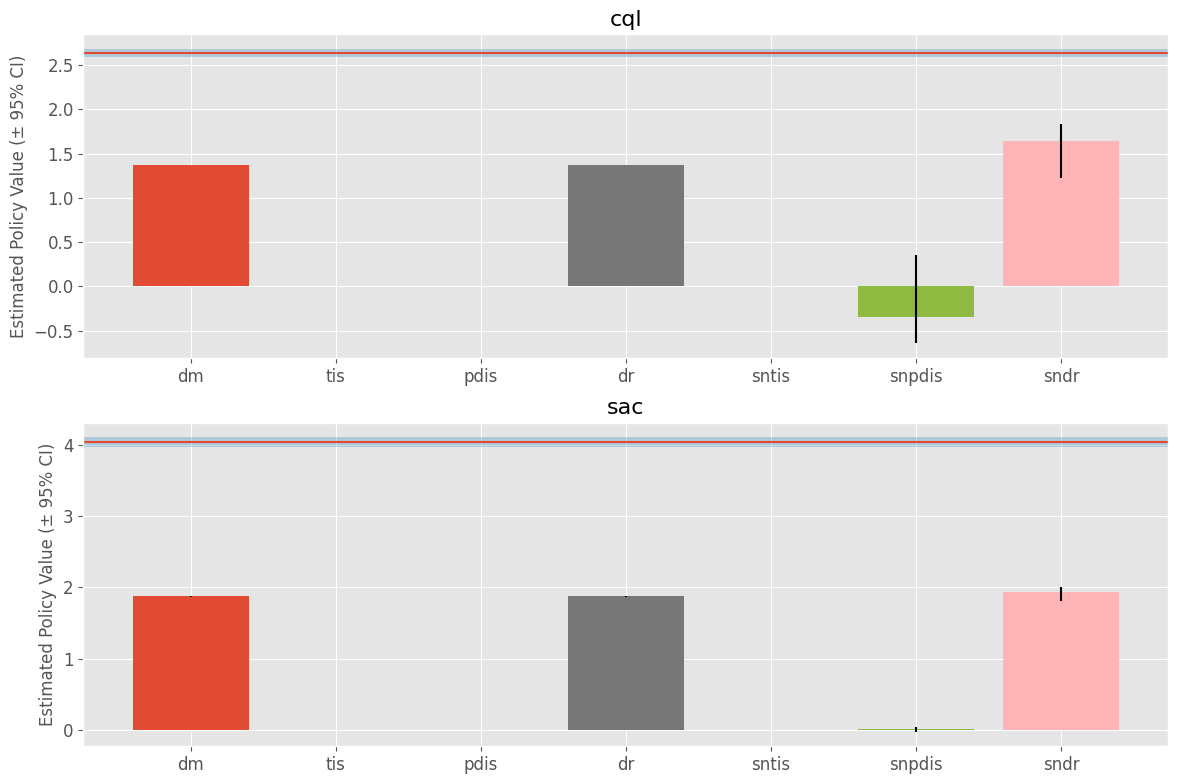

In [35]:
# visualize and compare the result
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=basic_estimators_name,
    random_state=random_state, 
    sharey=False,
)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

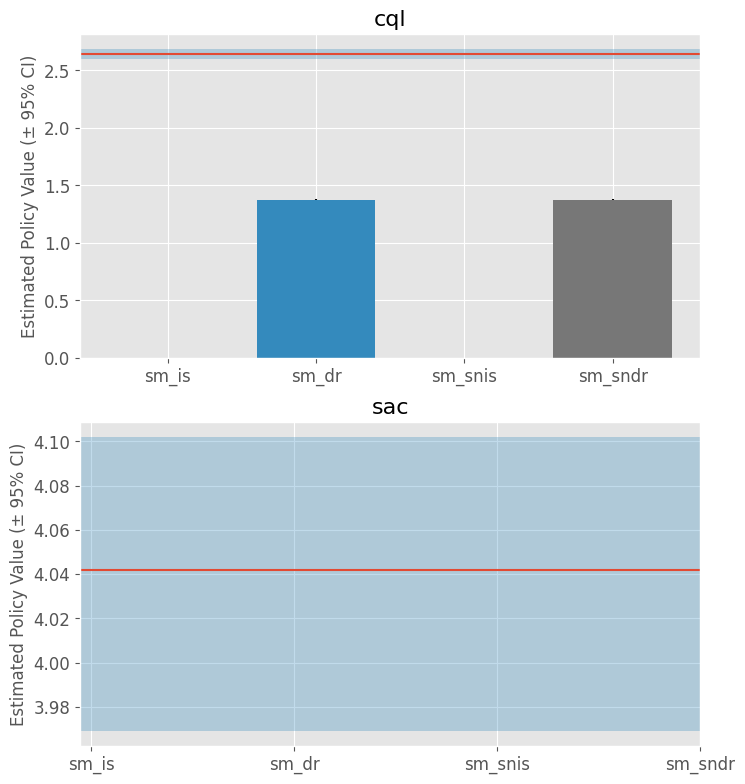

In [36]:
# visualize and compare the result
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=state_marginal_estimators_name,
    random_state=random_state, 
    sharey=False,
)

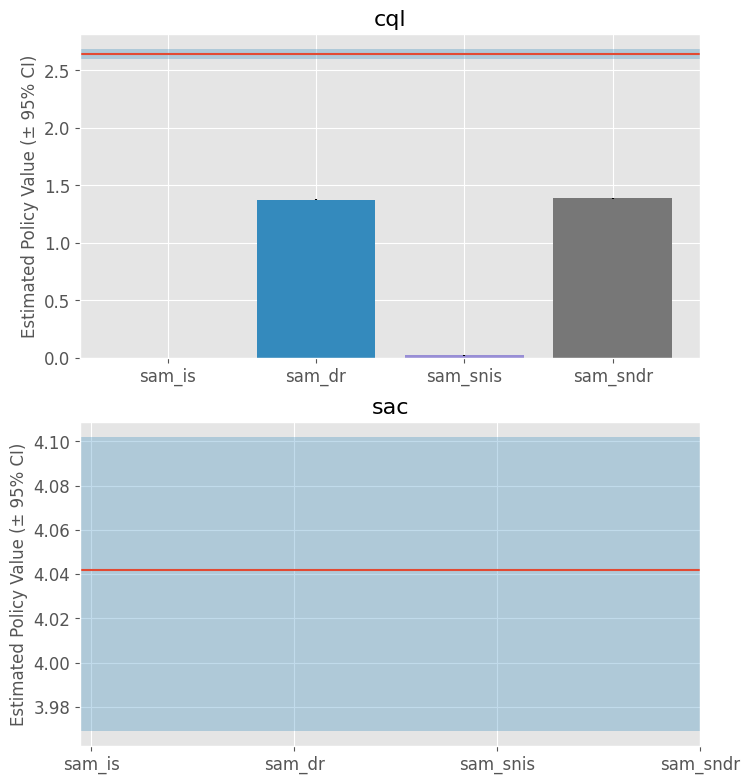

In [37]:
# visualize and compare the result
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=state_action_marginal_estimators_name,
    random_state=random_state, 
    sharey=False,
)

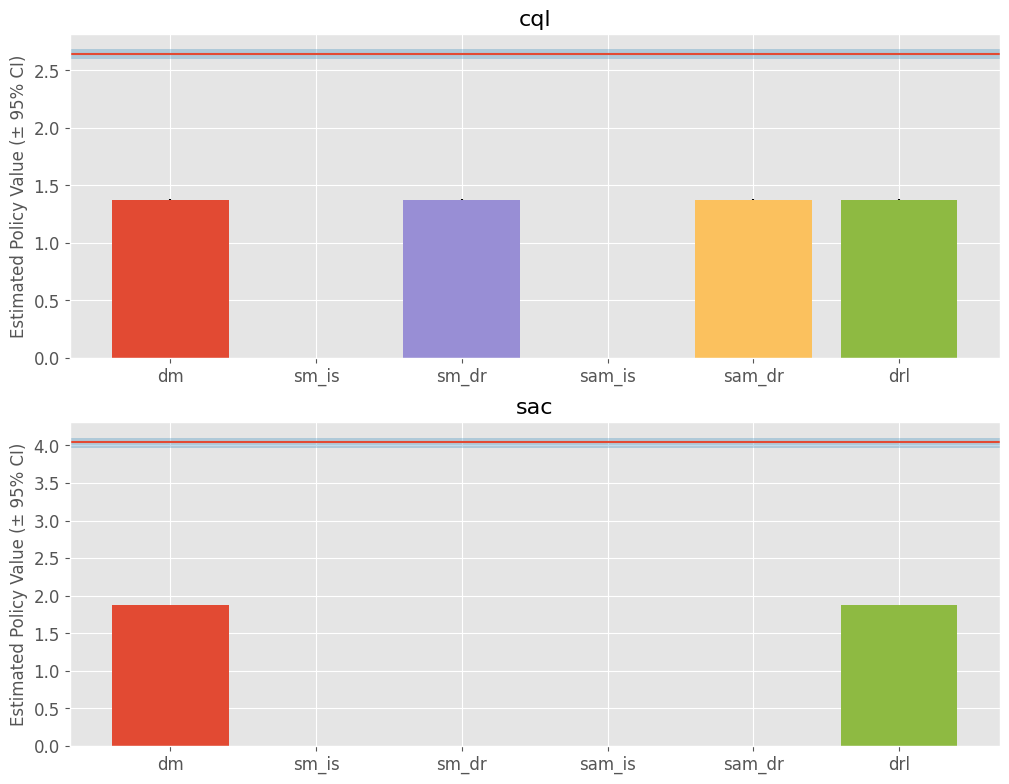

In [38]:
# visualize and compare the result
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=["dm", "sm_is", "sm_dr", "sam_is", "sam_dr", "drl"],
    random_state=random_state, 
    sharey=False,
)

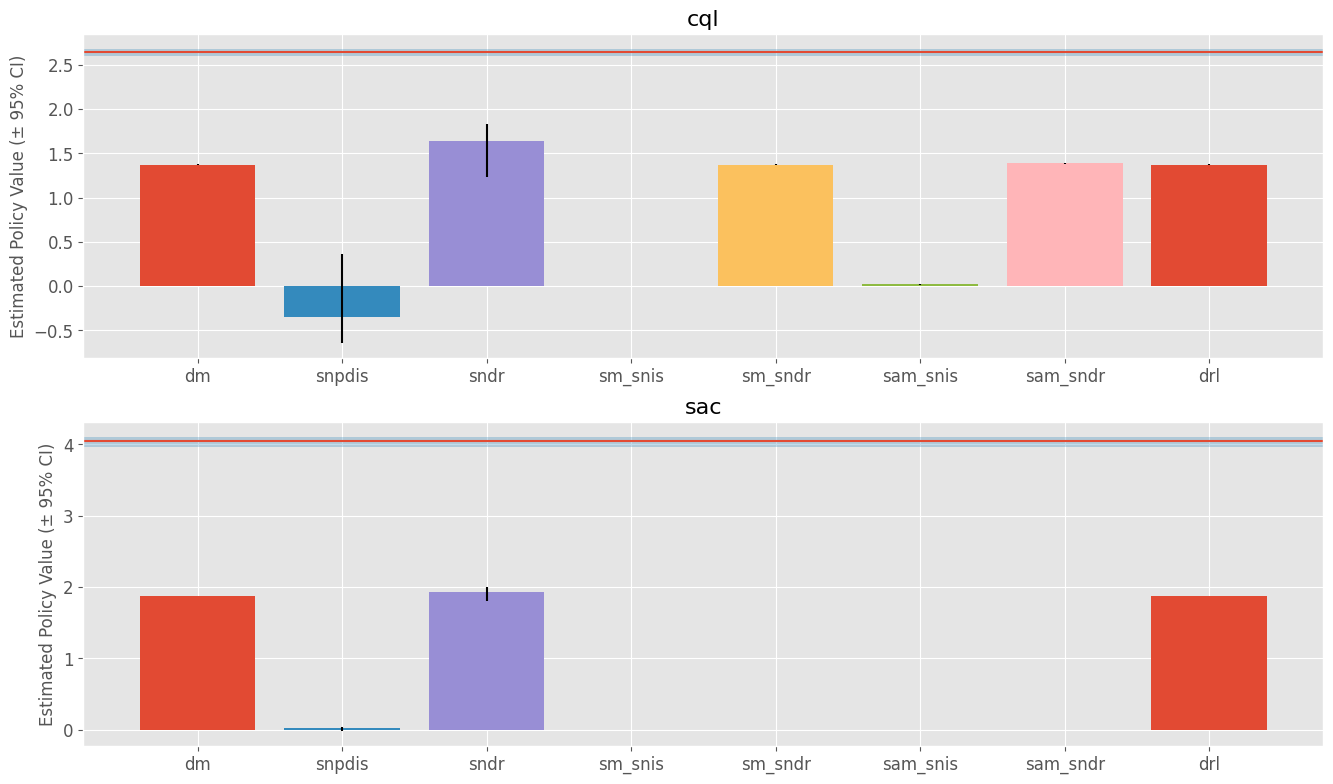

In [39]:
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=["dm", "snpdis", "sndr", "sm_snis", "sm_sndr", "sam_snis", "sam_sndr", "drl"],
    random_state=random_state, 
    sharey=False,
)

For more advanced topics in OPE (e.g., cumulative distribution function estimation) and OPS, please refer to [examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb). 

For the examples in the discrete action space, please refer to [examples/quickstart/basic/basic_synthetic_discrete_zoo.ipynb](https://github.com/negocia-inc/ofrl/blob/ope/examples/quickstart/basic/basic_synthetic_discrete_zoo.ipynb).

## Reference

- Haanvid Lee, Jongmin Lee, Yunseon Choi, Wonseok Jeon, Byung-Jun Lee, Yung-Kyun Noh, and Kee-Eung Kim. \
"Local Metric Learning for Off-Policy Evaluation in Contextual Bandits with Continuous Actions.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Christina J. Yuan, Yash Chandak, Stephen Giguere, Philip S. Thomas, and Scott Niekum. \
"SOPE: Spectrum of Off-Policy Estimators.", 2021.

- Nathan Kallus and Masatoshi Uehara. \
"Double Reinforcement Learning for Efficient Off-Policy Evaluation in Markov Decision Processes.", 2020.

- Masatoshi Uehara, Jiawei Huang, and Nan Jiang. \
"Minimax Weight and Q-Function Learning for Off-Policy Evaluation.", 2020.

- Mengjiao Yang, Ofir Nachum, Bo Dai, Lihong Li, and Dale Schuurmans. \
"Off-Policy Evaluation via the Regularized Lagrangian.", 2020.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Angela Zhou. \
"Policy Evaluation and Optimization with Continuous Treatments.", 2019.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Qiang Liu, Lihong Li, Ziyang Tang, and Dengyong Zhou. \
"Breaking the Curse of Horizon: Infinite-Horizon Off-Policy Estimation.", 2018

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.